## Price Estimates

- Data Source: `Kaggle`

#### Tasks:
- **Cleansing**
- **EDA**
- **Merge Additional Data by geo/zip**
- **K-Means Clustering**
- **Model Price**

In [43]:
#Import Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as SPLIT
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
import folium
warnings.filterwarnings("ignore")
from scipy import stats
import statsmodels.api as sm

In [3]:
df_raw = pd.read_csv('/Users/shebanaderzad/Downloads/kc_house_data.csv')
df_raw.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


## Merge Additional Data
- `Zip` or `city` as **Primary Key**
- Crime Data, Population Data, etc.

In [4]:
#Population Data #ON QI DATA
zip_df = pd.read_csv('/Users/shebanaderzad/Downloads/2010_Census_Populations_by_Zip_Code.csv').groupby('Zip Code')['Total Population'].max().reset_index() 
df_raw = df_raw.merge(zip_df, left_on='zipcode', right_on='Zip Code', how='left') #Relational Join
df_raw.drop(columns=['zipcode'], inplace=True) #DELLETE

## Cleansing
- Null Values + Outliers _`viz + stats`_

In [5]:
#Output z-score ranges for data distribution of a feature
def dist_range(df, col, z): 
    upper = round(df[col].mean() + (df[col].std())*z,4)
    lower = round(df[col].mean() - (df[col].std())*z,4)
    if lower<0:lower=0
    print(f'{col.title()} {z} Z-scores of Data: ({lower},{upper})') 

In [6]:
dist_range(df_raw, 'bathrooms',3) #QI DATA
dist_range(df_raw, 'bedrooms',3)
dist_range(df_raw, 'sqft_living',3)
dist_range(df_raw, 'price',3)

Bathrooms 3 Z-scores of Data: (0,4.4252)
Bedrooms 3 Z-scores of Data: (0.5807,6.161)
Sqft_Living 3 Z-scores of Data: (0,4835.2224)
Price 3 Z-scores of Data: (0,1641469.7312)


In [7]:
# Remove Outliers in Analysis Columns
df = df_raw.query('bathrooms <=5 and bedrooms <=7 and sqft_living <= 4500 and price<1500000')

In [8]:
import scipy
#Kurtosis, Original + Cleansed
scipy.stats.kurtosis(np.array(df_raw['price'])),  scipy.stats.kurtosis(np.array(df['price'])) 

(34.577262255687536, 1.6373459257029523)

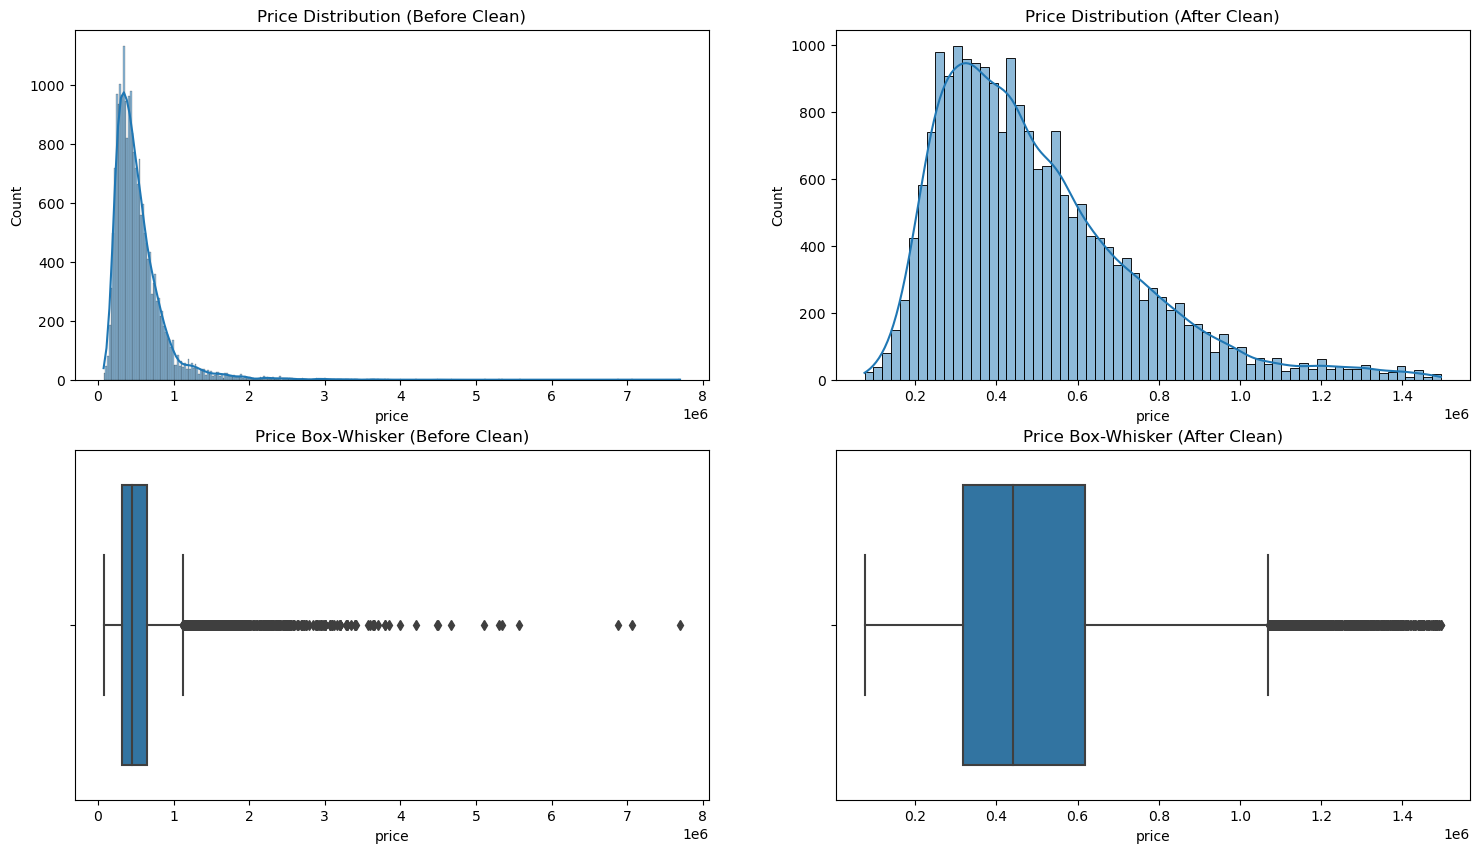

In [9]:
#View Outlier Mgmt
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].set_title('Price Distribution (Before Clean)')
sns.histplot(df_raw['price'], kde=True, ax=axes[0,0]);

axes[1,0].set_title('Price Box-Whisker (Before Clean)')
sns.boxplot(x=df_raw['price'],ax=axes[1,0]);

axes[0,1].set_title('Price Distribution (After Clean)')
sns.histplot(df['price'], kde=True, ax=axes[0,1]);

axes[1,1].set_title('Price Box-Whisker (After Clean)')
sns.boxplot(x=df['price'], ax=axes[1,1]);

In [10]:
pd.DataFrame(df.isnull().sum()).rename(columns={0:'Null_Count'})

,Null_Count
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


In [ ]:
#Engineer Days since prev_sold and peep corr

## EDA
- _Univariate_ Analysis of Price
- _Bivariate_ Analysis
- Correlation
- Sig. Testing

#### Distributions, Correlation, Multidimensional Viz 

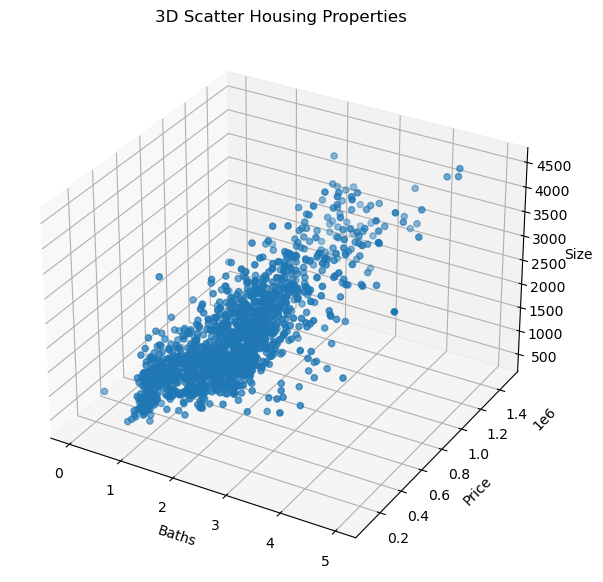

In [11]:
#QI DATA
fig = plt.figure(figsize=(7,9))
ax = plt.axes(projection = '3d') #3D scatter plot

sampled_df = df.sample(n=1500) #Sample df for Viz

ax.scatter(sampled_df['bathrooms'], sampled_df['price'], sampled_df['sqft_living'])

ax.set_xlabel('Baths')
ax.set_ylabel('Price')
ax.set_zlabel('Size')
ax.set_title('3D Scatter Housing Properties')
plt.show()

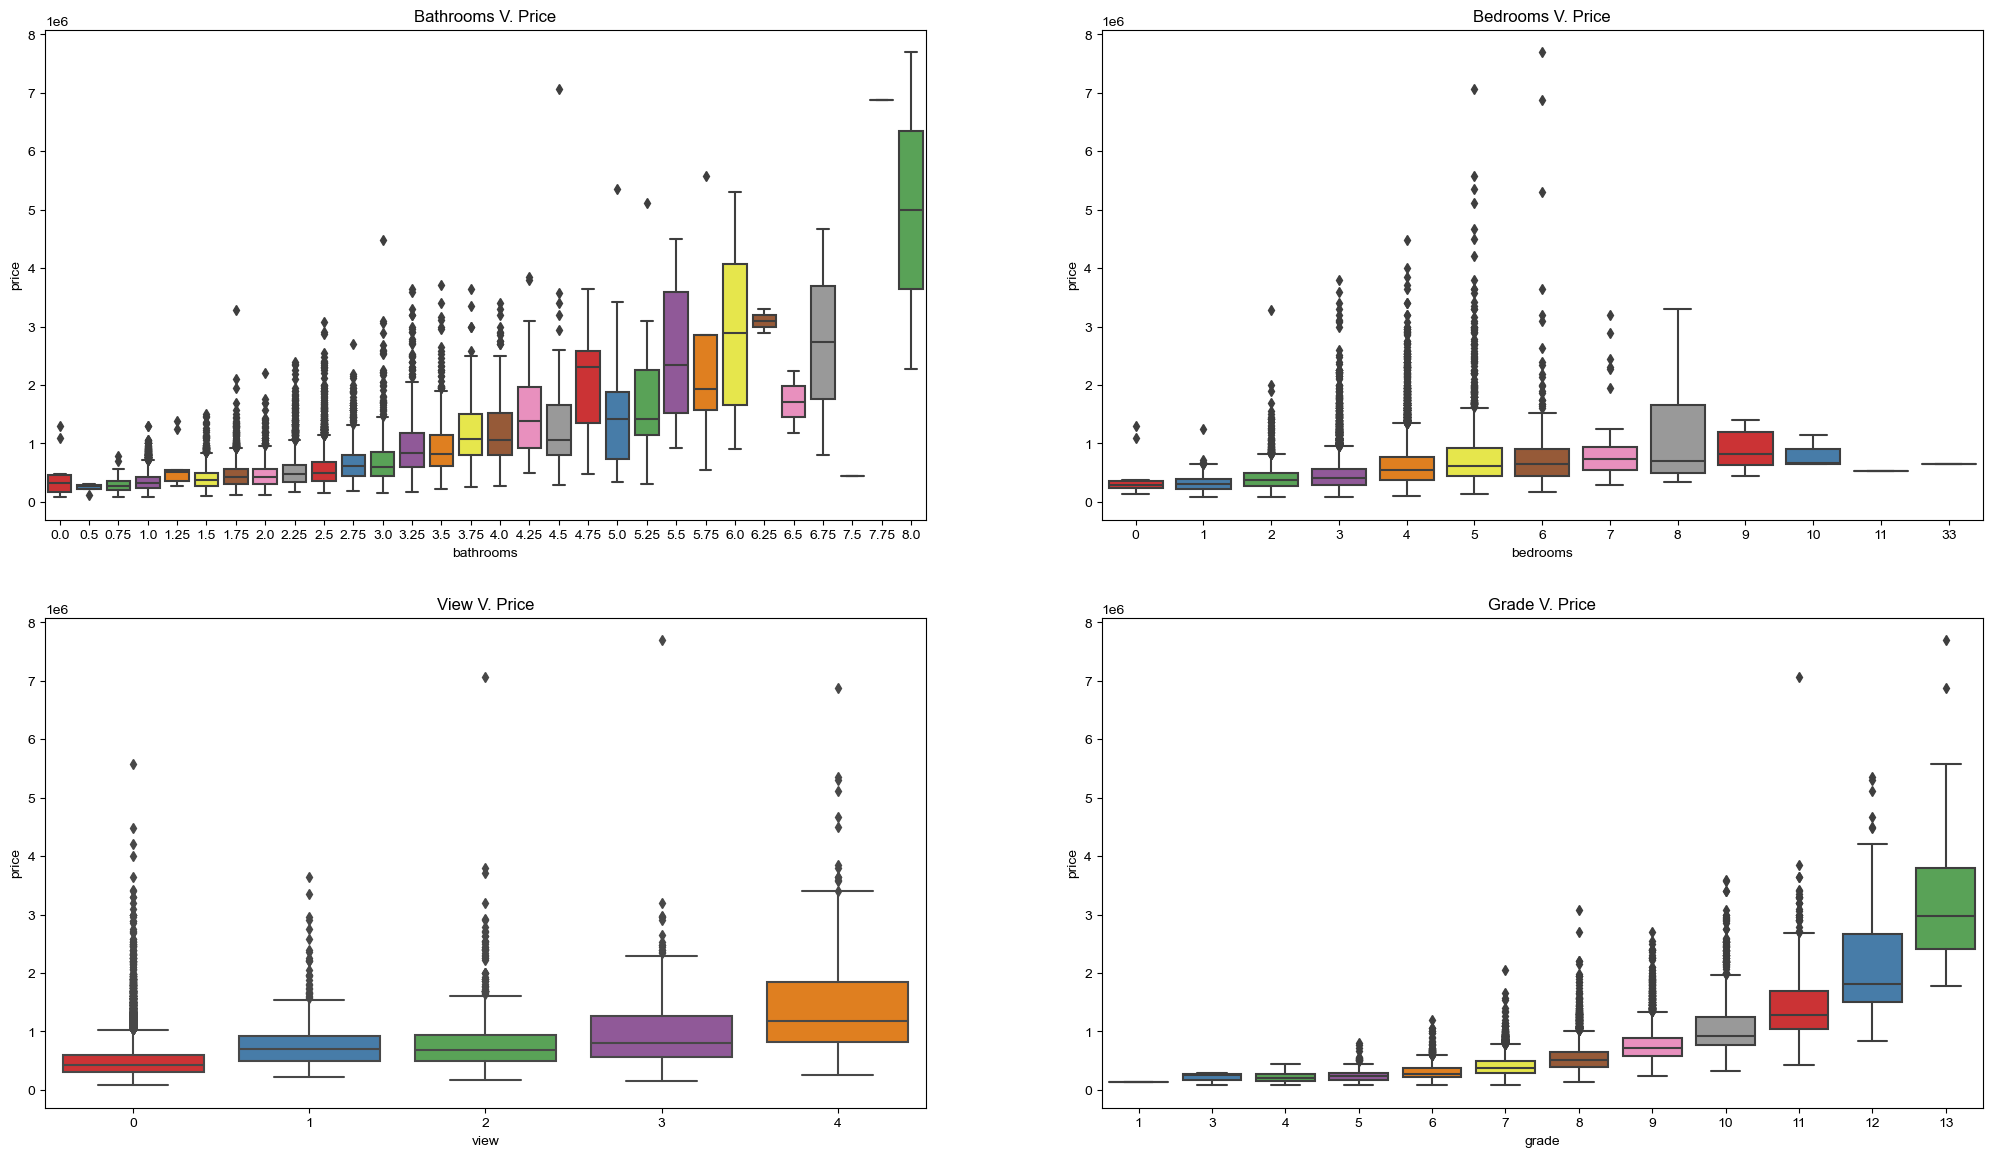

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(25, 14))
# plt.figure(figsize=(12, 8)) 
sns.set_style("darkgrid")

axes[0,0].set_title('Bathrooms V. Price')
sns.boxplot(x="bathrooms", y="price", data=df_raw, palette="Set1", ax=axes[0,0])

axes[0,1].set_title('Bedrooms V. Price')
sns.boxplot(x="bedrooms", y="price", data=df_raw, palette="Set1", ax=axes[0,1])

axes[1,0].set_title('View V. Price')
sns.boxplot(x="view", y="price", data=df_raw, palette="Set1", ax=axes[1,0])

axes[1,1].set_title('Grade V. Price')
sns.boxplot(x="grade", y="price", data=df_raw, palette="Set1", ax=axes[1,1]);

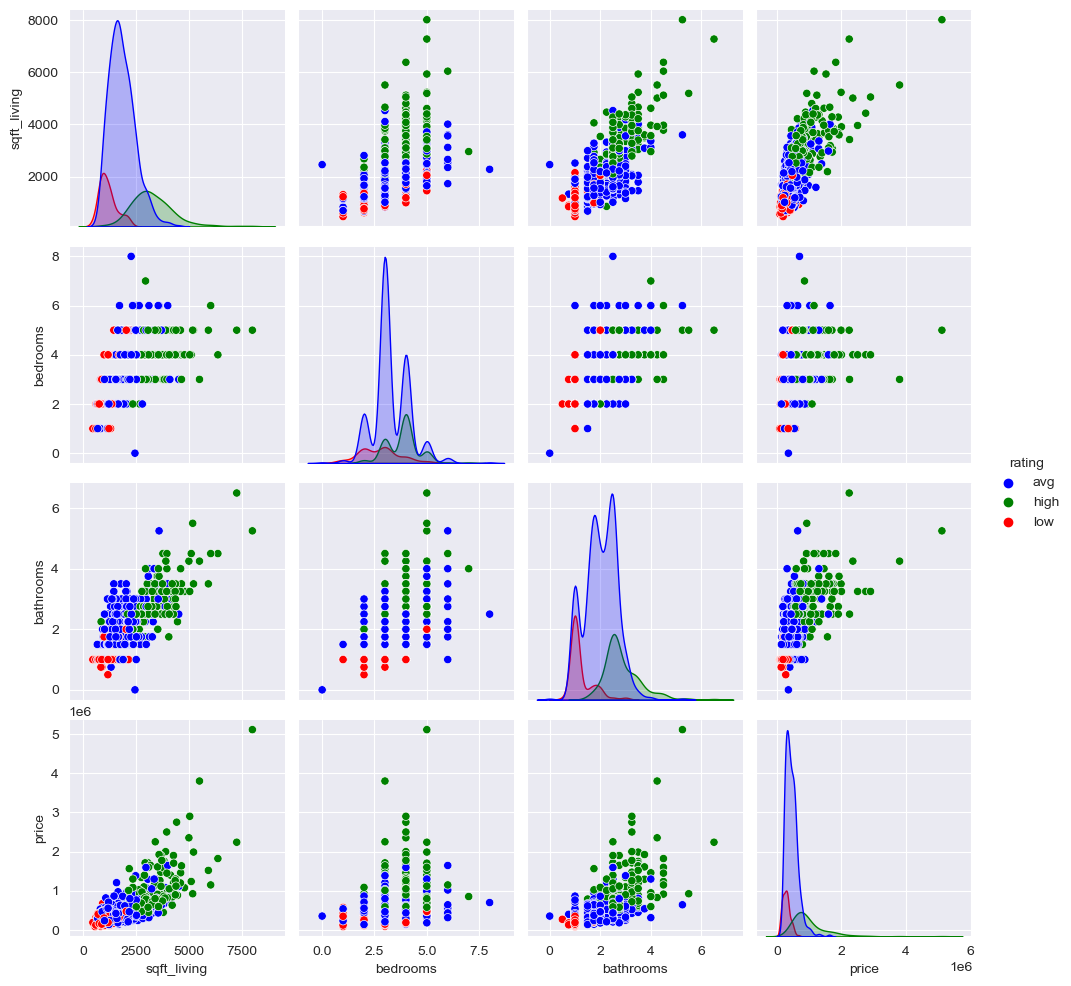

In [13]:
#Col Rating Engineered to better viz Grade
df_raw['rating'] = df_raw['grade'].apply(lambda i: 'low' if i <= 6 else 'avg' if i <= 8 else 'high')
sns.pairplot(data=df_raw[['sqft_living', 'rating', 'bedrooms','bathrooms', 'price']].sample(1000), hue='rating',
            palette={"low": "red", "avg": "blue", "high": "green"});

In [14]:
from sklearn.linear_model import LinearRegression #SQFT_Living LR VIZ
lr = LinearRegression()
lr.fit(np.array(df_raw['sqft_living']).reshape(-1, 1), np.array(df_raw['price']).reshape(-1, 1))

LinearRegression()

In [15]:
bo = lr.intercept_
b1 = lr.coef_
print('Intercept: {} \nSlope (Sqft): {}'.format(bo,b1))

Intercept: [-43580.74309448] 
Slope (Sqft): [[280.6235679]]


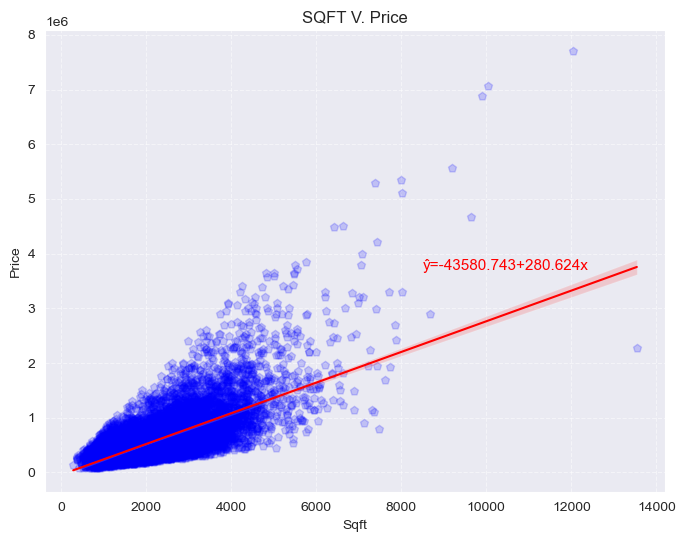

In [16]:
plt.figure(figsize=(8, 6))

sns.regplot(df_raw['sqft_living'], df_raw['price'], marker = 'p', scatter_kws={"color": "blue", "alpha": 0.18}, 
    line_kws={"color": "red", "linewidth": 1.5})
plt.xlabel('Sqft')
plt.ylabel('Price')
plt.title('SQFT V. Price')
plt.text(8500, 3700000, f'ŷ={round(bo[0],3)}+{round(b1[0][0],3)}x',fontsize=11, color='red')
plt.grid(True, linestyle='--', alpha=0.5);

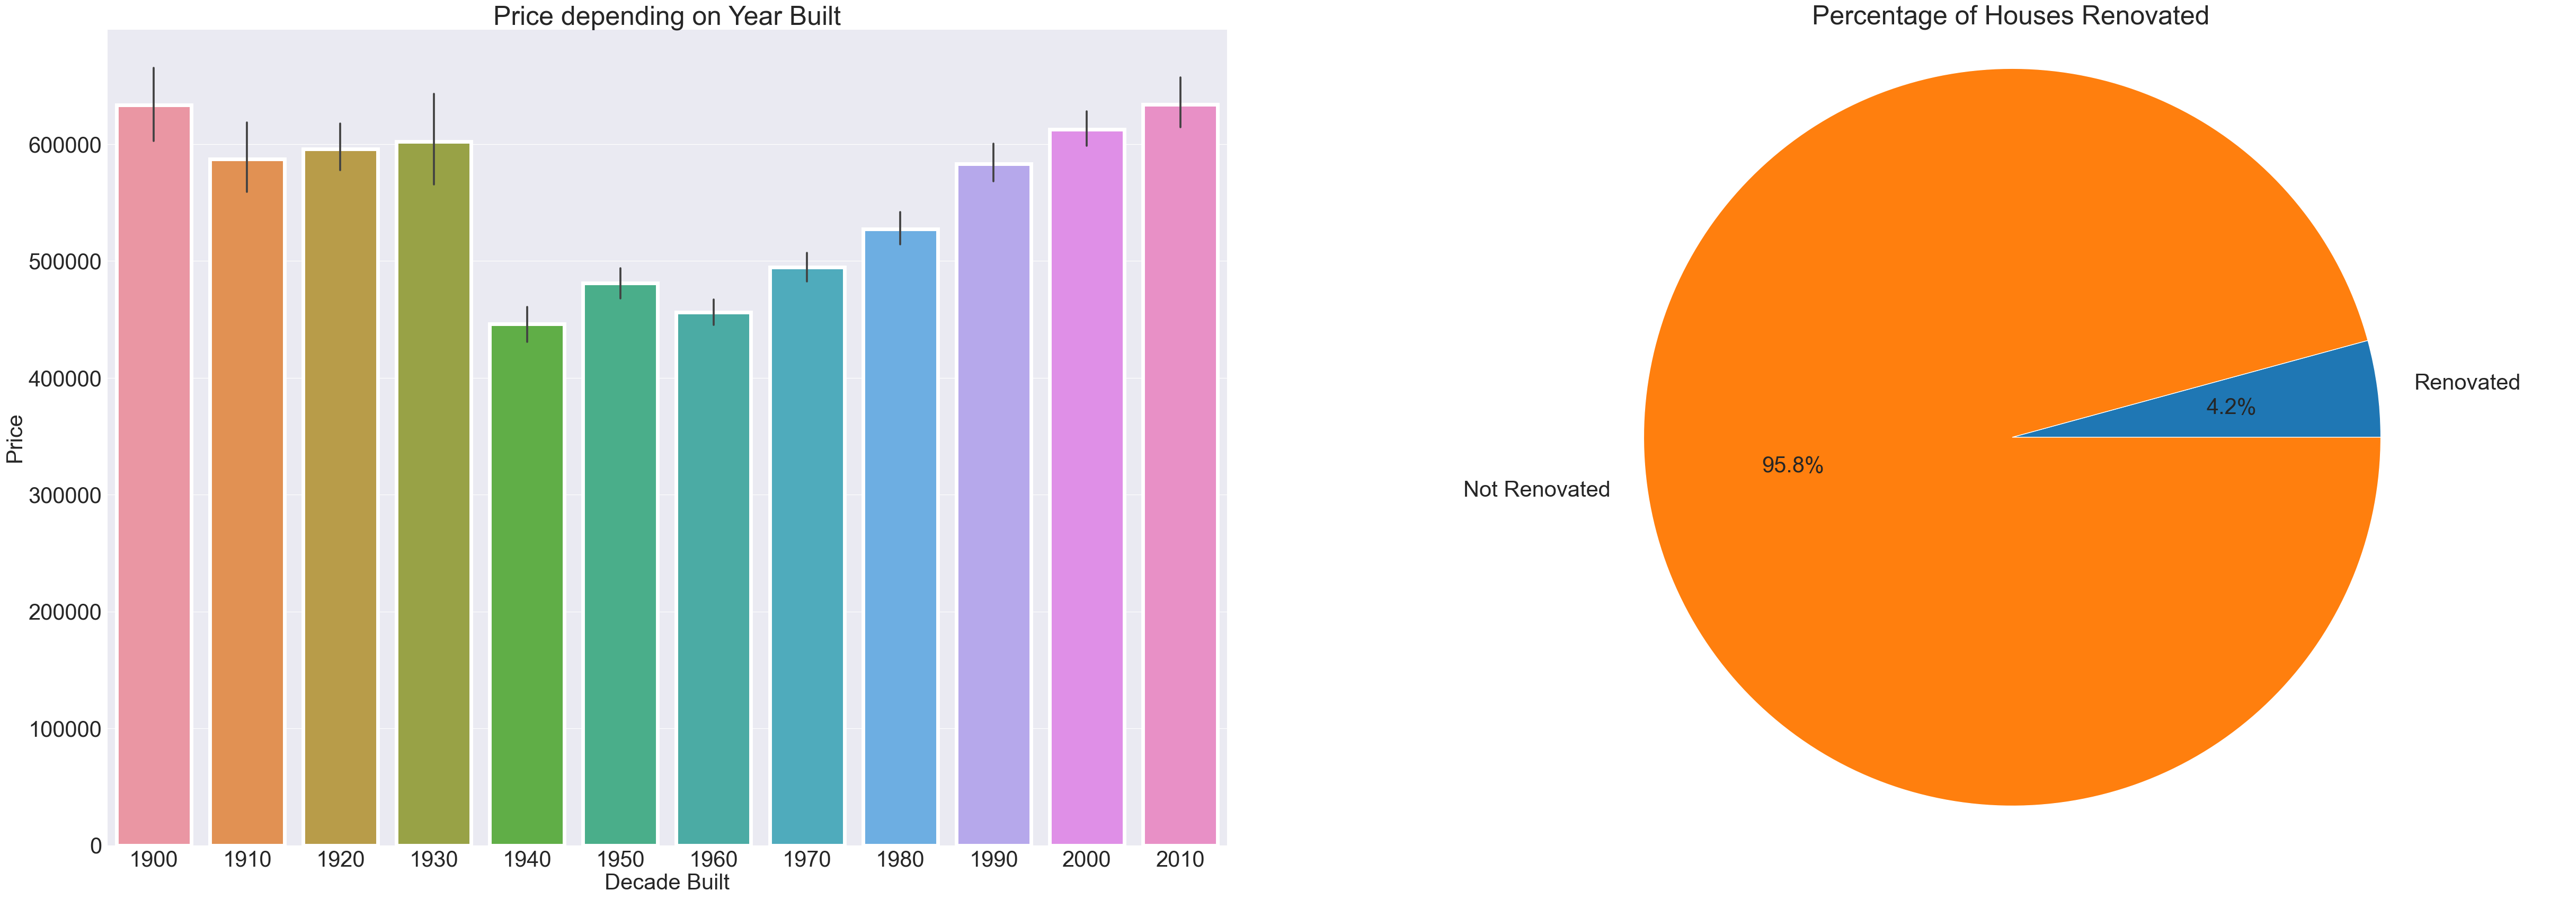

In [31]:
# Now, create a 'Decade' column by integer division to the nearest 10
df_raw['dc_built'] = (df_raw['yr_built'] // 10) * 10

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(60, 20))  # 1 row, 2 columns

plt.rcParams.update({'font.size': 30})

# First subplot: Bar Graph
sns.barplot(x='dc_built', y='price', data=df_raw, lw=5, ax=axs[0])
axs[0].set_title('Price depending on Year Built') 
axs[0].set_xlabel('Decade Built')                 
axs[0].set_ylabel('Price')                        
axs[0].tick_params(axis='x')                      
axs[0].tick_params(axis='y')                      


# Second subplot: Pie Chart
# Count number of houses that have been renovated
renovated_cnt = len(df_raw[df_raw['yr_renovated'] != 0])

# Calculate the total number of houses
total = len(df_raw)

# Calculate percentage
percentage_renovated = (renovated_cnt / total) * 100

# Create a pie chart
labels = ['Renovated', 'Not Renovated']
sizes = [percentage_renovated, 100 - percentage_renovated]

axs[1].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[1].set_title('Percentage of Houses Renovated')
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

Text(0, 0.5, 'Price')

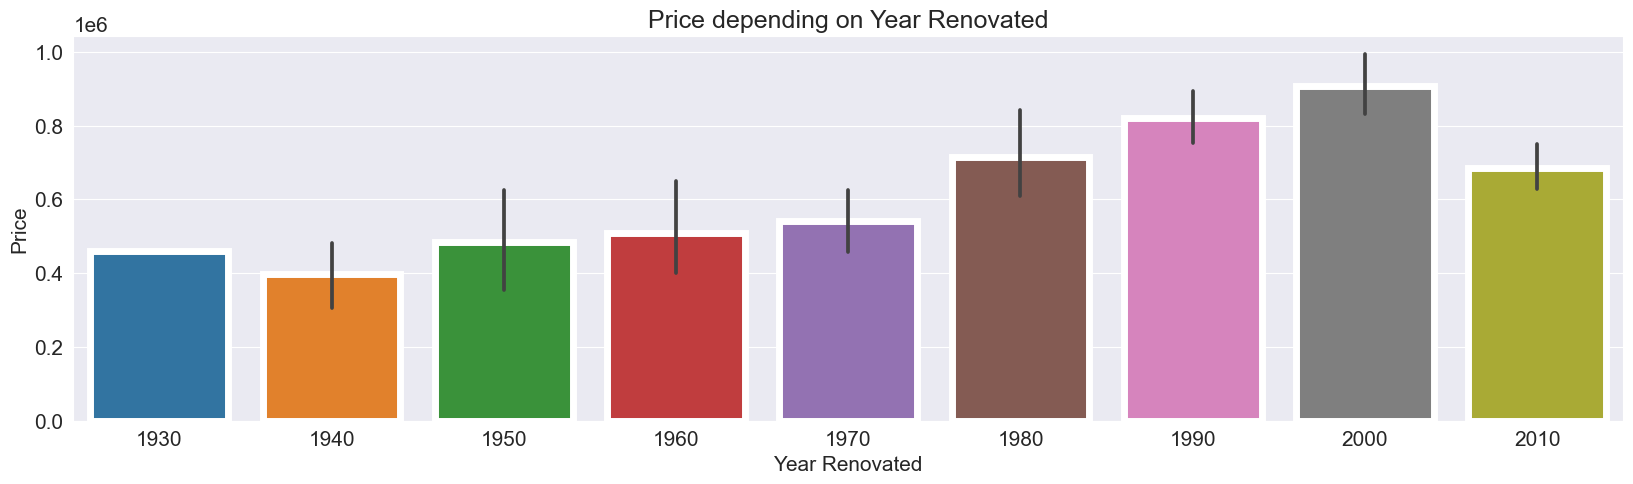

In [35]:
# Now, create a 'Decade' column by integer division to the nearest 10
df_raw['dc_renovated'] = (df_raw['yr_renovated'] // 10) * 10
#Plot bar graph price depending on year built 
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 5))
sns.barplot(x='dc_renovated', y='price', data=df_raw[df_raw['yr_renovated'] != 0], lw=5)
plt.title('Price depending on Year Renovated')
plt.xlabel('Year Renovated')
plt.ylabel('Price')

In [ ]:
#Viz by county/zip
https://towardsdatascience.com/a-quick-guide-to-beautiful-scatter-plots-in-python-75625ae67396
    

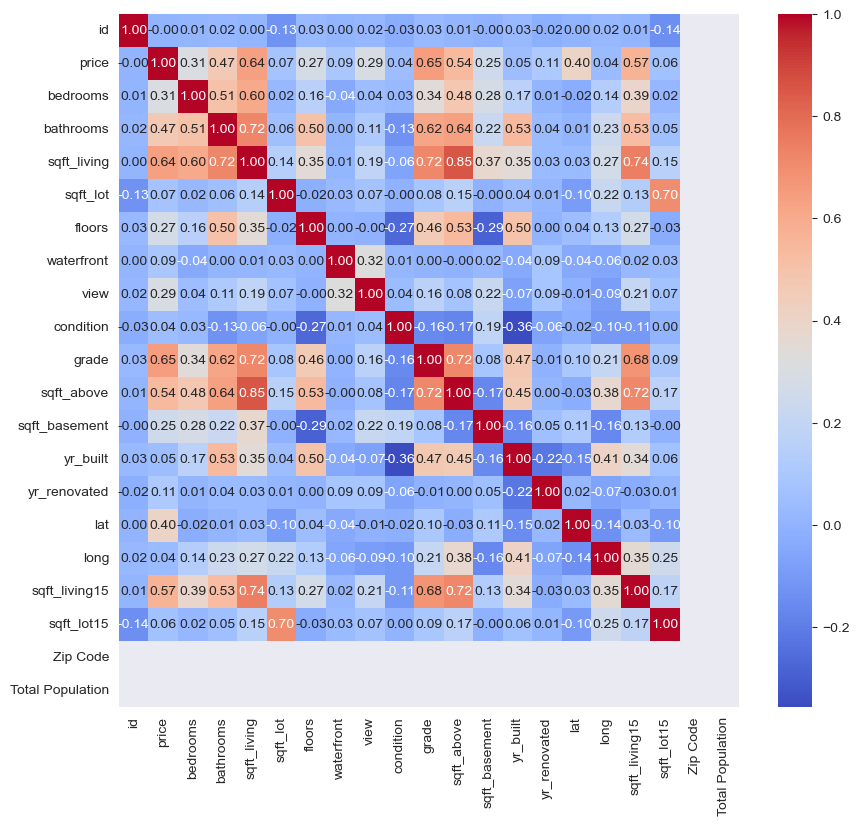

In [39]:
#plt.figure(figsize=(10,9))
#sns.heatmap(df.drop(columns=['index', 'OID_', 'id']).corr(), cmap='coolwarm', annot=True, fmt='.2f');

plt.figure(figsize=(10,9))
plt.rcParams.update({'font.size': 10})
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f');

In [ ]:
#Folium Map (ARNO)

## Hypothesis Testing

In [44]:
print(df.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'Zip Code', 'Total Population'],
      dtype='object')


In [47]:
# independent vars as X
X = df[['bedrooms', 'bathrooms','sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']] 
X = sm.add_constant(X)
#price as dependent
y = df['price']

# Fit the regression model
model = sm.OLS(y, X).fit()
# print out the summary stats
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     2407.
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:01:10   Log-Likelihood:            -2.7886e+05
No. Observations:               20884   AIC:                         5.577e+05
Df Residuals:                   20870   BIC:                         5.579e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.126e+06   1.01e+05     50.816

In [52]:
# Splitting the dataset
group1 = df[df['bathrooms'] >= 5]['price']
group2 = df[df['bathrooms'] < 5]['price']

# Performing a T-test
t_stat, p_value = stats.ttest_ind(group1, group2)

# Check the p-value
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Reject null hypothesis


In [42]:
# Splitting the dataset
group1 = df[df['sqft_living'] > 3000]['price']
group2 = df[df['sqft_living'] <= 3000]['price']

# Performing a T-test
t_stat, p_value = stats.ttest_ind(group1, group2)

# Check the p-value
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Reject null hypothesis


In [41]:
# Splitting the dataset
group1 = df[df['grade'] > 4]['price']
group2 = df[df['grade'] <= 4]['price']

# Performing a T-test
t_stat, p_value = stats.ttest_ind(group1, group2)

# Check the p-value
if p_value < 0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

Reject null hypothesis


## K-means Clustering 

In [ ]:
#Import Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [ ]:
df.reset_index(inplace=True)
df_k = df.copy() #df for K-means processes

### _Normalize Features_

In [ ]:
df_k.head(2)

In [ ]:
#QI DATA #Z-Scores 
scaler = StandardScaler()
df_k[['price_T', 'house_size_t', 'bath_t']] = scaler.fit_transform(df_k[['price', 'sqft_living', 'bathrooms']])

### _Elbow Function_

In [ ]:
def elbow(data, max_k): #Identify optimal K value respecting SSE
    k_vals = []
    sse = []
    
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        k_vals.append(k)
        sse.append(kmeans.inertia_)
        
    #Elbow Plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(k_vals, sse, 'o-')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.grid(True)
    plt.show()

In [ ]:
elbow(df_k[['price_T', 'house_size_t', 'bath_t']], 10) #QI DATA

## K-means application
- `k = 3`
- `vars = price, house_size, bathrooms`

In [ ]:
#QI DATA
kmeans = KMeans(n_clusters=3) #Fit data to Kmeans Algo
kmeans.fit(df_k[['price_T', 'bath_t', 'house_size_t']])

In [ ]:
df_k['kmeans_3_multi'] = kmeans.labels_ #Labels added to df

In [ ]:
#QI DATA
fig = plt.figure(figsize=(7,9))
ax = plt.axes(projection = '3d') #3D scatter plot

df_k_sampled = df_k.sample(2000, random_state=100) #Sample df for Viz

ax.scatter(df_k_sampled['price_T'], df_k_sampled['house_size_t'], df_k_sampled['bath_t'], c=df_k_sampled['kmeans_3_multi'])

ax.set_xlabel('price_T')
ax.set_ylabel('house_size_t')
ax.set_zlabel('bath_t')
ax.set_title('K-Means Algo (k=3)')
plt.show()

## Modeling Tasks
- `LR + RF + RF BOOSTED`